# Task-2. Build a Simple CNN for a Binary Classification Task:
   - Create a simple CNN architecture on the Cat-vs-Dog dataset and document   
   - Document the architecture of your CNN, including the number of layers, types of layers, and parameters used.
   - Train your CNN on the Cat-vs-Dog dataset and explore the use of callbacks (e.g., EarlyStopping, ModelCheckpoint) while training models.
   - Document the training process, including data preprocessing steps, training parameters (learning rate, batch size, epochs), and any challenges faced.
   - Evaluate the performance


In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'microsoft-catsvsdogs-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F550917%2F1003830%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240910%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240910T044909Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b80c0826425b235a7339834ad644a7bb356dba364ce522d5c7f2569d3db6bd909b2ec0ecbb695c85c36f5dfa721b606426fa16db69fd768c130cd55f1e277982a6d526aea21cf3c2914f27186c7f5adf38df900f2e4484edbc52a7d5dd702501c6e3186ecab9279656a702ae26c3b6cc5ead00d8b4e124e2de41658c2842f70b1bfaf3e5c92a95355690f7cc3d525e14faf9ad121a0b376e7cc69f5985dcdc85d947eb23c56d2979d784b1d1530ea1d692f9ec06a14f308cdd209c5f4fe43333e060fa09f3b13f163da62abbd073091033c94a3ee373d815e1fc082799e3251dbb30f05abc0ddb4878e92ac05c115c2e52045de16faf5f286d7f5f19925c6b4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 825979578 bytes downloaded
Downloaded and uncompressed: microsoft-catsvsdogs-dataset
Data source import complete.


# TASK NUMBER 1

 ### What are the advantages of convolutional layers over fully connected layers in image processing tasks?
Convolutional layers are more efficient in handling image data due to local connections and weight sharing, preserving spatial hierarchies. Fully connected layers ignore spatial structure and require many more parameters, making them inefficient for images.

 ###  How does pooling help in reducing the computational complexity of a CNN?
Pooling reduces computational complexity by downsampling feature maps, which helps reduce the number of parameters and computations, improving efficiency while retaining important information.

### Compare different types of pooling layers (max pooling, average pooling). What are their respective advantages and disadvantages?
Max vs. Average Pooling:

**Max Pooling:**
- Pro: Captures dominant features, making it effective for tasks where sharp edges are important.
- Con: Can miss subtle details.
  
**Average Pooling:**
- Pro: Maintains more detailed information.
- Con: Might blur the key features by averaging.










# **CATS vs DOGS Classification Using CNN**

## Import Libraries

In [2]:
# Standard library imports
import os
import shutil
import random

# Data handling
import numpy as np
import pandas as pd

# Machine Learning and Neural Network libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Dense, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# SciPy and Sklearn for additional functionalities
import scipy as sp
from scipy import ndimage
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [3]:

# File Paths for Dataset
cat_file_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat"
dog_file_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog"

## Dataset Class Visualization


In [4]:
import plotly.express as px

class_names = ['Cat', 'Dog']
n_dogs = len(os.listdir(cat_file_path))
n_cats = len(os.listdir(dog_file_path))
n_images = [n_cats, n_dogs]

fig = px.bar(x=class_names, y=n_images, color=class_names, labels={'x': 'Class', 'y': 'Number of Images'},
             title='Dataset Class Distribution')
fig.show()


## Splitting Dataset into train, validation, and test sets

In [5]:
# Data Splitting Function
def split_data(main_dir, split_size=0.9):
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files, len(files)) # shuffles the data
    split = int(split_size * len(shuffled_files)) # the training split casted into int for numeric rounding
    train_files = shuffled_files[:split] # training split
    split_valid_test = int(split + (len(shuffled_files) - split) / 2)

    validation_files = shuffled_files[split:split_valid_test] # validation split
    test_files = shuffled_files[split_valid_test:]

    return train_files, validation_files, test_files

# Split the data for cats and dogs
train_cats, val_cats, test_cats = split_data(cat_file_path)
train_dogs, val_dogs, test_dogs = split_data(dog_file_path)

print("Cats - Training:", len(train_cats), "Validation:", len(val_cats), "Test:", len(test_cats))
print("Dogs - Training:", len(train_dogs), "Validation:", len(val_dogs), "Test:", len(test_dogs))


Cats - Training: 11250 Validation: 625 Test: 625
Dogs - Training: 11250 Validation: 625 Test: 625


In [6]:
# Function to create a dataframe from file names and labels
def create_dataframe(file_names, label, main_dir):
    return pd.DataFrame({
        'filename': [os.path.join(main_dir, fname) for fname in file_names],
        'class': label
    })

# Create dataframes
train_df = pd.concat([create_dataframe(train_cats, 'cat', cat_file_path), create_dataframe(train_dogs, 'dog', dog_file_path)])
val_df = pd.concat([create_dataframe(val_cats, 'cat', cat_file_path), create_dataframe(val_dogs, 'dog', dog_file_path)])
test_df = pd.concat([create_dataframe(test_cats, 'cat', cat_file_path), create_dataframe(test_dogs, 'dog', dog_file_path)])

# Shuffle the dataframes
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

## Image Data Generators


In [7]:
# Image Data Generators

# Includes rescaling to normalize the image data. This transformation
# converts pixel values from the range [0, 255] to [0, 1], aiding in model training.
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen =  ImageDataGenerator(rescale=1./255.)
test_gen =  ImageDataGenerator(rescale=1./255.)

In [8]:
# Data Generators from Dataframes
train_generator = train_gen.flow_from_dataframe(dataframe=train_df, x_col='filename', y_col='class', target_size=(150, 150), batch_size=64, class_mode='binary')
validation_generator = validation_gen.flow_from_dataframe(dataframe=val_df, x_col='filename', y_col='class', target_size=(150, 150), batch_size=64, class_mode='binary')
test_generator = test_gen.flow_from_dataframe(dataframe=test_df, x_col='filename', y_col='class', target_size=(150, 150), batch_size=64, class_mode='binary')

Found 22498 validated image filenames belonging to 2 classes.
Found 1250 validated image filenames belonging to 2 classes.
Found 1250 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning:

Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.



In [12]:
# Function to Plot Data
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = next(generator)
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    plt.show()


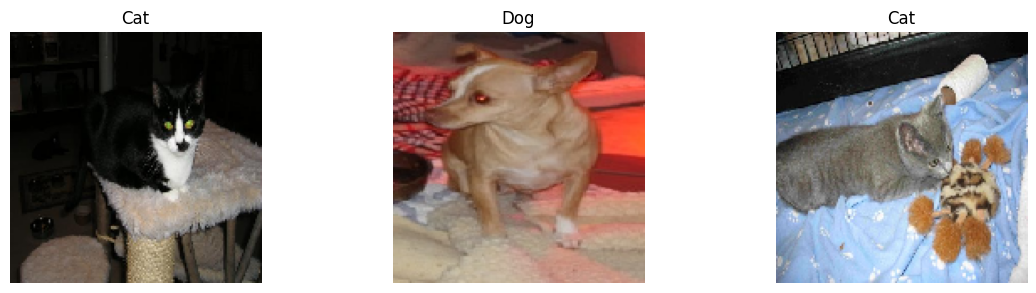

In [13]:
# Plotting Train Data Samples
plot_data(train_generator, 4)

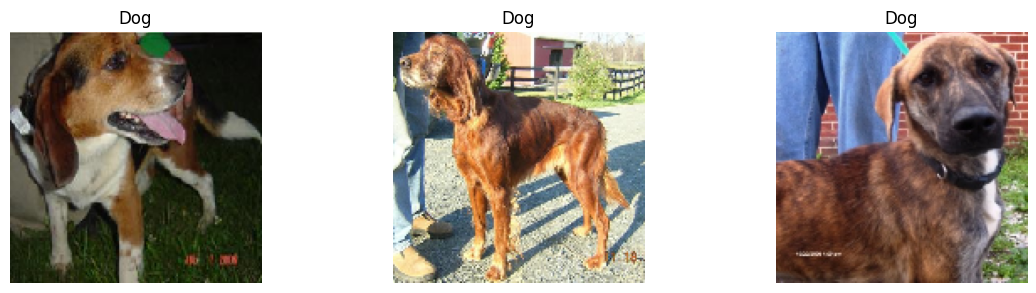

In [14]:
# Plotting Validation Data Samples
plot_data(validation_generator, 4)

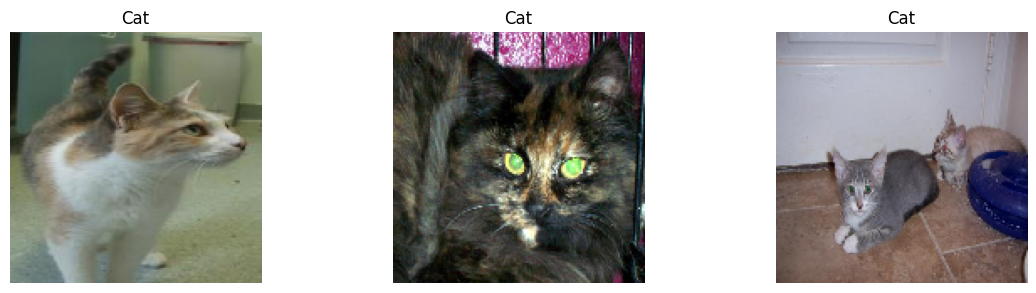

In [15]:
# Plotting Test Data Samples
plot_data(test_generator, 4)

## Model Architecture

In [16]:
# Building the CNN model
inputs = tf.keras.layers.Input(shape=(150,150,3))
# Convolutional layer with 32 filters of size 3x3, using ReLU activation function
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
# Another Convolutional layer with increased filters for capturing more complex features
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
# MaxPooling to reduce dimensionality and prevent overfitting
x = tf.keras.layers.MaxPooling2D(2,2)(x)

# Additional Convolutional layers with increasing filter size for deeper feature extraction
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)

# Global Average Pooling layer for reducing overfitting and improving model efficiency
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense layers for classification
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

## Model Training

In [20]:
# Model Compilation
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Training with ModelCheckpoint Callback
checkpoint_filepath = "epoch_at_{epoch:02d}.weights.h5" # Added .weights to the file name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    save_freq='epoch',  # Save weights every epoch
    verbose=1
)

# Model Training
r = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[model_checkpoint_callback]  # Add the callback here
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



195/352 ━━━━━━━━━━━━━━━━━━━━ 31s 202ms/step - accuracy: 0.5043 - loss: 0.6937

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning:

Truncated File Read



352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5087 - loss: 0.6931
Epoch 1: saving model to epoch_at_01.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 96s 214ms/step - accuracy: 0.5088 - loss: 0.6931 - val_accuracy: 0.6096 - val_loss: 0.6593
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6024 - loss: 0.6622
Epoch 2: saving model to epoch_at_02.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 105s 159ms/step - accuracy: 0.6024 - loss: 0.6622 - val_accuracy: 0.5520 - val_loss: 0.7171
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6415 - loss: 0.6361
Epoch 3: saving model to epoch_at_03.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.6415 - loss: 0.6361 - val_accuracy: 0.5792 - val_loss: 0.6773
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6758 - loss: 0.5999
Epoch 4: saving model to epoch_at_04.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 81s 154ms/step - accuracy: 0.6758 - loss: 0.5999 - val_accuracy: 0.6800 - val

## Model Evaluation


In [21]:
# Model Evaluation
model.evaluate(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.8874 - loss: 0.2973


[0.2864038050174713, 0.8855999708175659]

## Plot Predictions

In [24]:
# Function to Plot Predictions
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = next(generator)
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g')
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r')
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


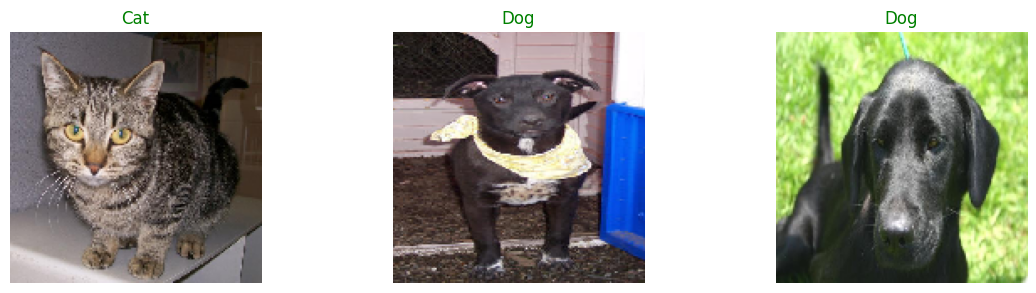

In [25]:
# Plotting Model Predictions on Validation set
plot_prediction(validation_generator, 4)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


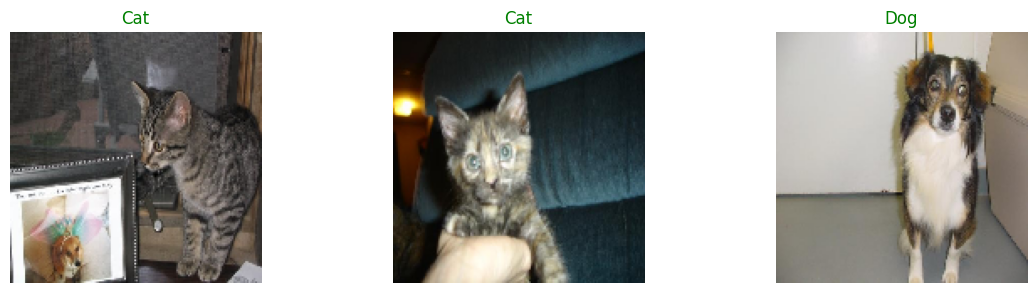

In [26]:
# Plotting Model Predictions on Test set
plot_prediction(test_generator, 4)

In [27]:
# Last Training Results
results = pd.DataFrame(r.history)
results.tail()

,accuracy,loss,val_accuracy,val_loss
15,0.831141,0.384197,0.8408,0.385676
16,0.840297,0.362000,0.7744,0.495173
17,0.846653,0.348252,0.8424,0.360294
18,0.859899,0.324504,0.8720,0.338620
19,0.869855,0.305072,0.8696,0.322104


## Training Metrics Visualization


In [28]:
fig = px.line(results, y=['accuracy', 'val_accuracy'],
              labels={'value': 'Accuracy', 'variable': 'Dataset'},
              template="plotly_dark")

fig.update_layout(
    title='Model Accuracy Over Epochs',
    title_font_color='white',
    xaxis=dict(color='white', title='Epochs'),
    yaxis=dict(color='white', title='Accuracy'),
    legend_title_text='Dataset'
)

fig.update_traces(marker=dict(size=8),
                  selector=dict(type='scatter', mode='lines+markers'))

fig.show()

In [29]:
fig = px.line(results, y=['loss', 'val_loss'],
              labels={'value': 'Loss', 'variable': 'Dataset'},
              template="plotly_dark")

fig.update_layout(
    title='Model Loss Over Epochs',
    title_font_color='white',
    xaxis=dict(color='white', title='Epochs'),
    yaxis=dict(color='white', title='Loss'),
    legend_title_text='Dataset'
)

fig.update_traces(marker=dict(size=8),
                  selector=dict(type='scatter', mode='lines+markers'))

fig.show()


## Confusion Matrix


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


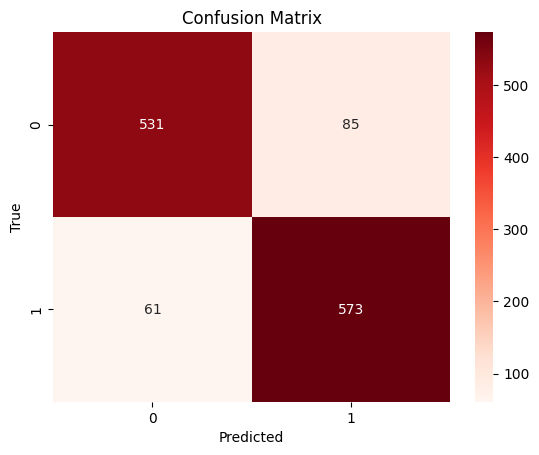

In [30]:
# Initialize arrays to store true labels and predictions
all_labels = []
all_predictions = []

# Loop over all batches in the test set
for _ in range(len(test_generator)):
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Append predictions and labels
    all_labels.extend(test_labels)
    all_predictions.extend(predicted_classes)

# Confusion matrix for the entire test set
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve and AUC


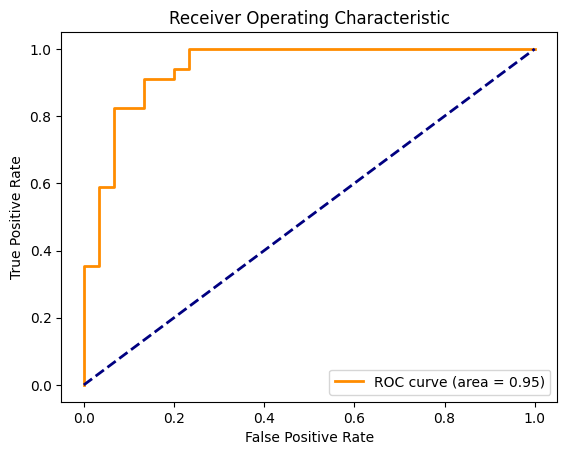

In [31]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(test_labels, predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()